In [608]:
import pandas as pd
import geopandas as gpd
 
def ee_array_to_df(arr, band):
    """
    We create a function with an array as input
    We return a pandas df
    """
    df = pd.DataFrame(arr)
     
    # we rearrange the header
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns = headers)
 
    # we remove raws without data inside:
    df = df[['longitude', 'latitude', 'time', band]].dropna()
     
    # We converr the data to numeric values
    df[band] = pd.to_numeric(df[band], errors='coerce')
     
    # We also convert the Time filed into a datetime
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')
     
    # We keep the columns we want
    # df = df[['time','datetime', band]]
     
    return df


def geojson2gee(geojson_path):
    """
    Use geopandas and google earth engine api to convert geojson to gee featurecollection 
    """
    
    shapefile = gpd.read_file(geojson_path)
    
    features = []
    for i in range(shapefile.shape[0]):
        geom = shapefile.iloc[i:i+1,:] 
        jsonDict = eval(geom.to_json()) 
        geojsonDict = jsonDict['features'][0] 
        features.append(ee.Feature(geojsonDict)) 

    gee_featurecollection = ee.FeatureCollection(features)
    
    return gee_featurecollection

In [660]:
# gee functions

"""
 * Function to mask clouds based on the pixel_qa band of Landsat SR data.
 * @param {ee.Image} image Input Landsat SR image
 * @return {ee.Image} Cloudmasked Landsat image
"""

def cloudMaskL457(image): 
    qa = image.select('pixel_qa');
    # If the cloud bit (5) is set and the cloud confidence (7) is high
    # or the cloud shadow bit is set (3), then it's a bad pixel.
    cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3));
    # Remove edge pixels that don't occur in all bands
    mask2 = image.mask().reduce(ee.Reducer.min());
    return image.updateMask(cloud.Not()).updateMask(mask2);

# functions for Indices
def addNDVI(image):
    ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI');
    return image.addBands(ndvi)

def addindex(image):
    ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI');
    ndwi = image.normalizedDifference(['B2', 'B5']).rename('NDWI');
    return image.addBands(ndvi).addBands(ndwi);

# create random points and add class using polgyons
def addpoints(feature, Class):
    def addclass(feature):
        return feature.set({'landuse': Class});
    trainpoints = ee.FeatureCollection.randomPoints(feature,1000,0);
    trainset = trainpoints.map(addclass)
    return trainset

# // Function to create a Make a Random Forest classifier and train it
# // given data from a specific year. 
def buildClassifier(range_data, bands, newfc, classProperty):
  
    #   // Sample the composite to generate training data.  Note that the
    #   // class label is stored in the 'landcover' property. 
    training_data = range_data.select(bands).sampleRegions(collection = newfc,
                                                           properties = [classProperty],
                                                           scale = 30);

    #   // Make a Random Forest classifier and train it
    classifier = ee.Classifier.randomForest(10).train(training_data, 'landuse');

    return classifier

In [609]:
# Import the Earth Engine Python Package
import ee # !pip install earthengine-api

# Import Dependencies
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from datetime import datetime
from matplotlib import dates
from pylab import *

import geopandas as gpd

ee.Initialize()

In [772]:
## Read polygons from file and apply as gee geometries
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
from shapely.ops import unary_union
import glob

# current working directory
import os
cwd = os.getcwd()

# find files in shapefile folder
shape_file_path = '../../data/city_outline/*.geojson'
shape_files = glob.glob(shape_file_path)
geojson_path = shape_files[0]

shape_files[0:3], cwd, path

(['../../data/city_outline/Jakarta_wgs.geojson'],
 '/home/ubuntu/rimbun.io/03_Add_metadata/02_green_area_change',
 '../../data/city_outline/Jakarta_wgs.geojson')

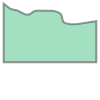

In [773]:
shapefile = gpd.read_file(geojson_path)

if len(shapefile) > 1:

    shapes_check = MultiPolygon([geom for geom in shapefile.geometry])
    
else:
    
    shapes_check = shapefile.geometry[0]
    
shapes_check

In [774]:
rect = geojson2gee(geojson_path)


In [775]:
# // Import GEE data /////////////////////////////////////////////////////

LS5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterDate('1986-01-01', '2000-12-31');
  
LE7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterDate('2001-01-01', '2018-12-31');

LS5NDVI = LS5.map(addNDVI);
LE7NDVI = LE7.map(addNDVI);

y1 = LS5NDVI.filterDate('1988-01-01', '1989-12-31').map(cloudMaskL457).mean().set('system:time_start', '1989');
y2 = LS5NDVI.filterDate('1990-01-01', '1991-12-31').map(cloudMaskL457).mean().set('system:time_start', '1991');
y3 = LS5NDVI.filterDate('1992-01-01', '1993-12-31').map(cloudMaskL457).mean().set('system:time_start', '1993');
y4 = LS5NDVI.filterDate('1994-01-01', '1995-12-31').map(cloudMaskL457).mean().set('system:time_start', '1995');
y5 = LS5NDVI.filterDate('1996-01-01', '1997-12-31').map(cloudMaskL457).mean().set('system:time_start', '1997');
y6 = LS5NDVI.filterDate('1998-01-01', '1999-12-31').map(cloudMaskL457).mean().set('system:time_start', '1999');   
y7 = LE7NDVI.filterDate('2000-01-01', '2001-12-31').map(cloudMaskL457).mean().set('system:time_start', '2001');
y8 = LE7NDVI.filterDate('2002-01-01', '2003-12-31').map(cloudMaskL457).mean().set('system:time_start', '2003');
y9 = LE7NDVI.filterDate('2004-01-01', '2005-12-31').map(cloudMaskL457).mean().set('system:time_start', '2005');
y10 = LE7NDVI.filterDate('2006-01-01', '2007-12-31').map(cloudMaskL457).mean().set('system:time_start', '2007');
y11 = LE7NDVI.filterDate('2008-01-01', '2009-12-31').map(cloudMaskL457).mean().set('system:time_start', '2009');
y12 = LE7NDVI.filterDate('2010-01-01', '2011-12-31').map(cloudMaskL457).mean().set('system:time_start', '2011');
y13 = LE7NDVI.filterDate('2012-01-01', '2013-12-31').map(cloudMaskL457).mean().set('system:time_start', '2013');
y14 = LE7NDVI.filterDate('2014-01-01', '2015-12-31').map(cloudMaskL457).mean().set('system:time_start', '2015');   
y15 = LE7NDVI.filterDate('2016-01-01', '2018-12-31').map(cloudMaskL457).mean().set('system:time_start', '2018');
y16 = LE7NDVI.filterDate('2019-01-01', '2020-06-04').map(cloudMaskL457).mean().set('system:time_start', '2020');

# //add indices (NDVI / NDWI, see functions) 
y1 = addindex(y1);
y2 = addindex(y2);
y3 = addindex(y3);
y4 = addindex(y4);
y5 = addindex(y5);
y6 = addindex(y6);
y7 = addindex(y7);
y8 = addindex(y8);
y9 = addindex(y9);
y10 = addindex(y10);
y11 = addindex(y11);
y12 = addindex(y12);
y13 = addindex(y13);
y14 = addindex(y14);
y15 = addindex(y15);

In [776]:
# Import training data /////////////////////////////////////////////////////

# 1. Get polygons from geojson
# 2. generate random points in polygons
# 3. use random points in training algorithm
# 4. use trained classifier to predict classes for all pixels

water_shape_file_path = '../../data/hand_annotations/gee_training_data/water*.geojson'
urban_shape_file_path = '../../data/hand_annotations/gee_training_data/urban*.geojson'
vegetation_shape_file_path = '../../data/hand_annotations/gee_training_data/vegetation*.geojson'

water_shape_files = glob.glob(water_shape_file_path)[0]
urban_shape_files = glob.glob(urban_shape_file_path)[0]
vegetation_shape_files = glob.glob(vegetation_shape_file_path)[0]


feature_collection_water = geojson2gee(water_shape_files)
feature_collection_urban = geojson2gee(urban_shape_files)
feature_collection_vegetation = geojson2gee(vegetation_shape_files)

# use the polygon data to create random training points
urban = addpoints(feature_collection_water,1);
water = addpoints(feature_collection_urban,2);
vegetation = addpoints(feature_collection_vegetation,3);

# // Merge the three geometry layers into a single FeatureCollection.
newfc = urban.merge(vegetation).merge(water)

In [777]:

# print(newfc)
# // Use these bands for classification.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI','NDWI'];
# // The name of the property on the points storing the class label.
classProperty = 'landuse';



In [778]:
# Classify the composite, use function to create a separate classifier for each year. 
classified1 = y1.classify(buildClassifier(y1, bands, newfc, classProperty)).set('system:time_start', '1989');
classified2 = y2.classify(buildClassifier(y2, bands, newfc, classProperty)).set('system:time_start', '1991');
classified3 = y3.classify(buildClassifier(y3, bands, newfc, classProperty)).set('system:time_start', '1993');
classified4 = y4.classify(buildClassifier(y4, bands, newfc, classProperty)).set('system:time_start', '1995')
classified5 = y5.classify(buildClassifier(y5, bands, newfc, classProperty)).set('system:time_start', '1997');
classified6 = y6.classify(buildClassifier(y6, bands, newfc, classProperty)).set('system:time_start', '1999');
classified7 = y7.classify(buildClassifier(y7, bands, newfc, classProperty)).set('system:time_start', '2001');
classified8 = y8.classify(buildClassifier(y8, bands, newfc, classProperty)).set('system:time_start', '2003');
classified9 = y9.classify(buildClassifier(y9, bands, newfc, classProperty)).set('system:time_start', '2005');
classified10 = y10.classify(buildClassifier(y10, bands, newfc, classProperty)).set('system:time_start', '2007');
classified11 = y11.classify(buildClassifier(y11, bands, newfc, classProperty)).set('system:time_start', '2009');
classified12 = y12.classify(buildClassifier(y12, bands, newfc, classProperty)).set('system:time_start', '2011');
classified13 = y13.classify(buildClassifier(y13, bands, newfc, classProperty)).set('system:time_start', '2013');
classified14 = y14.classify(buildClassifier(y14, bands, newfc, classProperty)).set('system:time_start', '2015');
classified15 = y15.classify(buildClassifier(y15, bands, newfc, classProperty)).set('system:time_start', '2017');

In [779]:
classified_collection = ee.ImageCollection([classified1, classified2, 
classified3, classified4, classified5, classified6, classified7, 
classified8, classified9, classified10, classified11, classified12, 
classified13, classified14, classified15])

In [781]:
gee_data_array = classified_collection.getRegion(rect, scale = 500).getInfo()

In [613]:
## Example geometry structure
# feature_geometry = {
#     'type': 'MultiPolygon',
#     'coordinates': [[[
#         [-120, 35],
#         [-120.001, 35],
#         [-120.001, 35.001],
#         [-120, 35.001],
#         [-120, 35]
#     ]]]
# }

In [614]:
# convert geometry to JSON format
rect_JSON = rect.getInfo()#['coordinates']
rect_JSON['type']

'FeatureCollection'

In [615]:
# set variables
SCALE = 10;
polarization = 'VV'; # Polygonvertical/vertical or vertical/horizontal

In [621]:
# initiate google earth engine to aquire the image
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filterDate('2019-01-01', '2019-12-12')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
.select(polarization)\
.filterBounds(rect)\


In [599]:
scale_list = [10, 20, 100, 200, 300]

In [622]:

for scale_factor in scale_list:

    try: 
        # visualize resulting image
        img_url = S1.first().getThumbUrl({
            'region':rect.geometry(),
            'scale': scale_factor,
            'min':-25,
            'max':0,
            'palette':['0784b5', '39ace7', '9bd4e4', 'cadeef', 'ffffff'],
            'maxPixels': 1e9
        })
        print('succes at scale ' + str(scale_factor))
        break
    except Exception as e:
        print(e, '\nerror at scale ' + str(scale_factor))
        continue





Image(url = img_url)


Total request size (45394272 bytes) must be less than or equal to 33554432 bytes. 
error at scale 10
succes at scale 20


In [629]:
img_url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9108ea14650bcd8dd6cadd22396fdde7-aa916c55de0f3856acd04b226577f1ea:getPixels'

In [630]:
isinstance(rect, ee.ComputedObject)

True

In [631]:


for scale_factor in scale_list:

    try: 
        gee_data_array = S1.getRegion(rect, scale = scale_factor).getInfo()
        print('succes at scale ' + str(scale_factor))
        break
    except:
        print('error at scale ' + str(scale_factor))
        continue
        

succes at scale 10


In [782]:
df = ee_array_to_df(gee_data_array, 'classification')

In [791]:
df

,longitude,latitude,time,classification,datetime,geometry
0,106.318,-6.3713,1989,3,1970-01-01 00:00:01.989,POINT (106.31786 -6.37130)
1,106.318,-6.3713,1991,3,1970-01-01 00:00:01.991,POINT (106.31786 -6.37130)
2,106.318,-6.3713,1993,3,1970-01-01 00:00:01.993,POINT (106.31786 -6.37130)
3,106.318,-6.3713,1995,3,1970-01-01 00:00:01.995,POINT (106.31786 -6.37130)
4,106.318,-6.3713,1997,3,1970-01-01 00:00:01.997,POINT (106.31786 -6.37130)
5,106.318,-6.3713,1999,3,1970-01-01 00:00:01.999,POINT (106.31786 -6.37130)
6,106.318,-6.3713,2001,3,1970-01-01 00:00:02.001,POINT (106.31786 -6.37130)
7,106.318,-6.3713,2003,3,1970-01-01 00:00:02.003,POINT (106.31786 -6.37130)
8,106.318,-6.3713,2005,3,1970-01-01 00:00:02.005,POINT (106.31786 -6.37130)
9,106.318,-6.3713,2007,3,1970-01-01 00:00:02.007,POINT (106.31786 -6.37130)


In [793]:
df.time.unique()

array(['1989', '1991', '1993', '1995', '1997', '1999', '2001', '2003',
       '2005', '2007', '2009', '2011', '2013', '2015', '2017'],
      dtype=object)

In [785]:
import geopandas as gpd

In [786]:
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude))

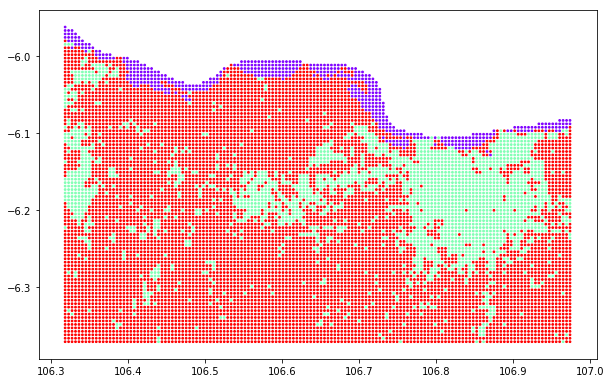

In [808]:
gdf[gdf.time == '1989'].plot(figsize = (10,10), 
                             column='classification', 
                             categorical=True, 
                             cmap='rainbow',
                             s = 3)

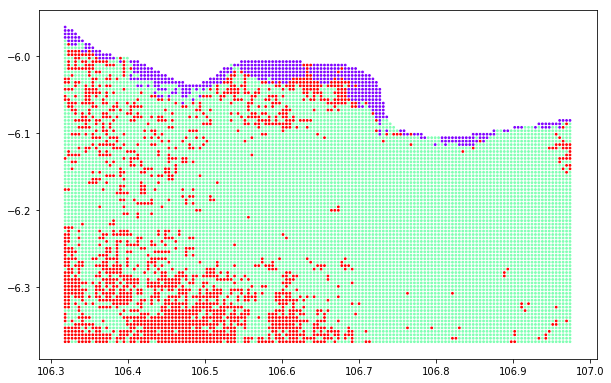

In [807]:
gdf[gdf.time == '2017'].plot(figsize = (10,10), 
                             column='classification', 
                             categorical=True, 
                             cmap='rainbow',
                             s = 3)

In [471]:
gdf.VV[0:5]

0   -11.716133
1    -7.660871
2    -7.470847
3    -9.131988
4   -11.700050
Name: VV, dtype: float64

In [804]:
import imageio

# download image as np array
im = imageio.imread(img_url)

# apply value mask
array_mask = np.array(im == 0).astype(int)

print(array_mask.shape)

# plot results
plt.figure(figsize = (20,20))
plt.subplot(121)
plt.imshow(im, cmap = 'jet')
plt.subplot(122)
plt.imshow(-array_mask[:,:,0], cmap = 'Blues')

HTTPError: HTTP Error 401: Unauthorized